# Position estimation experiments

This notebook serves to document various experiments performed on IMU data used to estimate position of a device. 

In [166]:
# Imports
import os
import datetime
import csv
import sys
import scipy as sp
from scipy import integrate
from scipy import signal
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D

# Local functions
sys.path.append("..") 
from imu.position_estimation import *

In [167]:
# Load data

session_uuid = "2ac38da9-c8bc-4227-974a-bbe242006df4"

# IMU data
parent_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
path_to_imu_data_processed = parent_path + "/datasets/" + "session-" + session_uuid + "/imu_data/processed/"

timestamp = pd.read_csv(path_to_imu_data_processed + "timestamp.csv").values
user_acceleration = pd.read_csv(path_to_imu_data_processed + "user_acceleration.csv")



In [169]:
# Time delta calculation
# Calculate the average time delta between sensor measurements
time = np.array([datetime.datetime.strptime(x[0], '%Y-%m-%d:%H:%M:%S.%f') for x in timestamp])

deltas = []
for i in range(len(time) - 1):
    deltas.append(calculate_delta(time[i+1], time[i]))

dt = np.array(deltas).mean()
print("Average sample period:\t", dt, "(s)")

Average sample period:	 0.019906759906759906 (s)


In [170]:
# Adjust of acceleration bias


# To get bias, first run "imu_gps_noise_analysis" notebook
# Read in bias values from _noise.csv

addBias = True

noise = np.zeros(6)
if addBias:
    # path_to_imu_data_processed = 
    # sess = "9317ce65-27b7-488e-9433-527d6fe350f5"
    path_to_csv_file=path_to_imu_data_processed+"user_acceleration_noise.csv"
    csv_file = open(path_to_csv_file)
    csvreader = csv.reader(csv_file)
    header = next(csvreader)
    row = next(csvreader)
    noise = list(map(lambda x: float(x), row))

# acceleration = []
# acceleration.append(np.array([a-bias_x for a in user_acceleration.x.values]))
# acceleration.append(np.array([a-bias_y for a in user_acceleration.y.values]))
# acceleration.append(np.array([a-bias_z for a in user_acceleration.z.values]))

# Convert accelerometer measurements from G's to m/s^2
acceleration = []
acceleration.append(np.array([convert_accelerometer(a, noise[0]) for a in user_acceleration.x.values]))
acceleration.append(np.array([convert_accelerometer(a, noise[2]) for a in user_acceleration.y.values]))
acceleration.append(np.array([convert_accelerometer(a, noise[4]) for a in user_acceleration.z.values]))

for acc in acceleration:
    acc = acc[:100]


Mean (x):	 0.0
Mean (y):	 1.290957005378089e-19
Mean (z):	 -4.3892538182855025e-18
Time:	 8.54


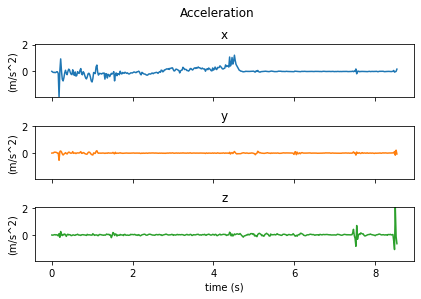

In [171]:
# Acceleration 

startTime = time[0]
ts = [calculate_delta(x, startTime) for x in time]

fig, axs = plt.subplots(3)
fig.tight_layout()
fig.suptitle("Acceleration")
fig.subplots_adjust(top=0.85)

axs[0].plot(ts, acceleration[0], color = "tab:blue")
axs[1].plot(ts, acceleration[1], color = "tab:orange")
axs[2].plot(ts, acceleration[2], color = "tab:green")

axs[0].set_ylim(min(min(acceleration[0]), min(acceleration[1]), min(acceleration[2])), max(max(acceleration[0]), max(acceleration[1]), max(acceleration[2])))
axs[1].set_ylim(min(min(acceleration[0]), min(acceleration[1]), min(acceleration[2])), max(max(acceleration[0]), max(acceleration[1]), max(acceleration[2])))
axs[2].set_ylim(min(min(acceleration[0]), min(acceleration[1]), min(acceleration[2])), max(max(acceleration[0]), max(acceleration[1]), max(acceleration[2])))


axs[0].set_title('x')
axs[1].set_title('y')
axs[2].set_title('z')

axs[0].set_ylabel("(m/s^2)")
axs[1].set_ylabel("(m/s^2)")
axs[2].set_ylabel("(m/s^2)")
axs[2].set_xlabel("time (s)")

for ax in fig.get_axes():
    ax.label_outer()

print("Mean (x):\t", acceleration[0].mean())
print("Mean (y):\t", acceleration[1].mean())
print("Mean (z):\t", acceleration[2].mean())

print("Time:\t", dt*(len(acceleration[0])-1))

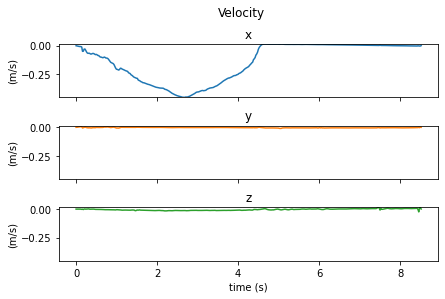

In [172]:
# Velocity

velocity = []
velocity.append(numericalIntegration(y=acceleration[0], dx=dt))
velocity.append(numericalIntegration(y=acceleration[1], dx=dt))
velocity.append(numericalIntegration(y=acceleration[2], dx=dt))

# Detrend result of integration to eliminate drift errors
for v in velocity:
    v = signal.detrend(v)

fig, axs = plt.subplots(3)
fig.tight_layout()
fig.suptitle("Velocity")
fig.subplots_adjust(top=0.85)

axs[0].plot(ts[:-1], velocity[0], color = "tab:blue")
axs[1].plot(ts[:-1], velocity[1], color = "tab:orange")
axs[2].plot(ts[:-1], velocity[2], color = "tab:green")

axs[0].set_ylim(min(min(velocity[0]), min(velocity[1]), min(velocity[2])), max(max(velocity[0]), max(velocity[1]), max(velocity[2])))
axs[1].set_ylim(min(min(velocity[0]), min(velocity[1]), min(velocity[2])), max(max(velocity[0]), max(velocity[1]), max(velocity[2])))
axs[2].set_ylim(min(min(velocity[0]), min(velocity[1]), min(velocity[2])), max(max(velocity[0]), max(velocity[1]), max(velocity[2])))

axs[0].set_title('x')
axs[1].set_title('y')
axs[2].set_title('z')

axs[2].set_xlabel("time (s)")
axs[0].set_ylabel("(m/s)")
axs[1].set_ylabel("(m/s)")
axs[2].set_ylabel("(m/s)")

for ax in fig.get_axes():
    ax.label_outer()


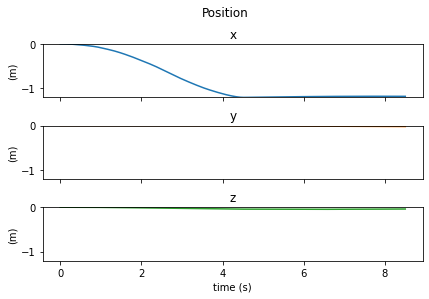

In [173]:
# Position

position = []
position.append(integrate.cumulative_trapezoid(y=velocity[0], dx=dt))
position.append(integrate.cumulative_trapezoid(y=velocity[1], dx=dt))
position.append(integrate.cumulative_trapezoid(y=velocity[2], dx=dt))

# Detrend result of integration to eliminate drift errors
for p in position:
    p = signal.detrend(p)

fig, axs = plt.subplots(3)
fig.tight_layout()
fig.suptitle("Position")
fig.subplots_adjust(top=0.85)

axs[0].plot(ts[:-2], position[0], color = "tab:blue")
axs[1].plot(ts[:-2], position[1], color = "tab:orange")
axs[2].plot(ts[:-2], position[2], color = "tab:green")

axs[0].set_ylim(min(min(position[0]), min(position[1]), min(position[2])), max(max(position[0]), max(position[1]), max(position[2])))
axs[1].set_ylim(min(min(position[0]), min(position[1]), min(position[2])), max(max(position[0]), max(position[1]), max(position[2])))
axs[2].set_ylim(min(min(position[0]), min(position[1]), min(position[2])), max(max(position[0]), max(position[1]), max(position[2])))

axs[0].set_title('x')
axs[1].set_title('y')
axs[2].set_title('z')

axs[2].set_xlabel("time (s)")
axs[1].set_ylabel("(m)")
axs[0].set_ylabel("(m)")
axs[2].set_ylabel("(m)")

for ax in fig.get_axes():
    ax.label_outer()


P_0:	 -3.461181984148848e-05 6.566736692690837e-06 -1.2846911089008057e-05
P_1:	 -1.1834041241630118 -0.023169170509546647 -0.03997801960377624


/var/folders/00/gk5sbk2j43n15xwxrqjn9fdc0000gn/T/ipykernel_1848/4081347787.py:11: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


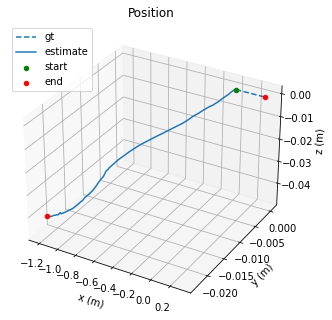

In [174]:
# Position — 3D view

N = len(position[0])
gt_pos = [
    np.linspace(0, 0.30, N, endpoint=True),
    np.zeros(N),
    np.zeros(N)
]

fig = plt.figure()
ax = Axes3D(fig)
plt.title('Position')
ax.plot3D(gt_pos[0], gt_pos[1], gt_pos[2], linestyle = '--', color="tab:blue")
ax.plot3D(position[0], position[1], position[2], color="tab:blue")

# Start and end points
ax.scatter(position[0][0], position[1][0], position[2][0], color='green', marker='o')
ax.scatter(position[0][-1], position[1][-1], position[2][-1], color='red', marker='o')
ax.scatter(gt_pos[0][-1], gt_pos[1][-1], gt_pos[2][-1], color='red', marker='o')

ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_zlabel('z (m)')

# ax.set_xlim(min(min(position[0]), min(position[1]), min(position[2])), max(max(position[0]), max(position[1]), max(position[2])))
# ax.set_ylim(min(min(position[0]), min(position[1]), min(position[2])), max(max(position[0]), max(position[1]), max(position[2])))
# ax.set_zlim(min(min(position[0]), min(position[1]), min(position[2])), max(max(position[0]), max(position[1]), max(position[2])))

print("P_0:\t", position[0][0], position[1][0], position[2][0])
print("P_1:\t", position[0][-1], position[1][-1], position[2][-1])

plt.legend(["gt", "estimate", "start", "end"], loc="upper left")

# ax.view_init(0, 90)

# Plot ground truth
